In [1]:
import copy
import os
import random
from enum import Enum

import cv2 as cv
import cv2

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# About the project

*This project will seek to discover if machine learning models can train on two different datasets
and still deliver acceptable results. The two datasets in question are MNIST and SVHN,
both datasets containing numbers. The MNIST dataset contains handwritten digits of a single color,
whereas SVHN contains house numbers in different shapes and colors. We will use a siamese model to see
if the model can learn features despite its differences in numerical shapes. In addition, we will
use a model with two identical networks in parallel, without weight sharing, where each network will
have it's own dataset of focus.*

# Startphase
*Before we set up the models and the training we must familiarize with the datasets used.*

## Loading the MNIST dataset
*The MNIST dataset is available through the torchvision package*

In [2]:
mnist_train_dataset = torchvision.datasets.MNIST(root="data", download=True, transform=ToTensor(), train=True)
mnist_test_dataset = torchvision.datasets.MNIST(root="data", download=True, transform=ToTensor(), train=False)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Loading the SVHN dataset
*The SVHN dataset is also available through torchvision. However, it has a different logic for splitting into train, test and extra*

In [3]:
svhn_train_dataset = torchvision.datasets.SVHN(root="data", split='extra', download=True, transform=ToTensor())
svhn_test_dataset = torchvision.datasets.SVHN(root="data", split='test', download=True, transform=ToTensor())


  0%|          | 0/1329278602 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

## Visualizing the MNIST dataset
*As seen below, the MNIST dataset is pretty simple and contains a fairly unanimous representation*

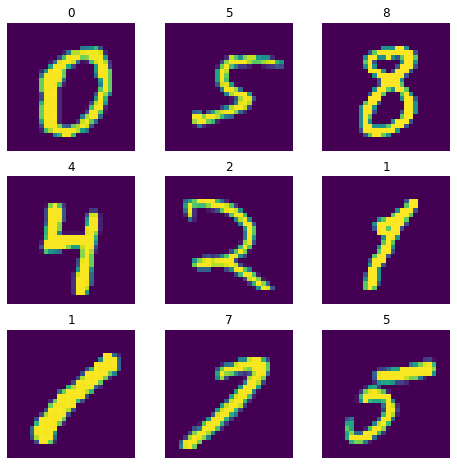

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(mnist_train_dataset), size=(1,)).item()
    img, label = mnist_train_dataset[sample_idx]
    ax = figure.add_subplot(rows, cols, i)
    ax.set_title(label)
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

## Visualizing the SVHN dataset
*The SVHN dataset differs from the MNIST dataset in several ways. Some images are nearly impossible to interpret,
some contains several digits, and all of them are colored. To bridge the gap between these two datasets we will explore
some image processing techniques that may help us. Here we are visualising the "extra" split, as this will be used in
training due to it's clearer images.

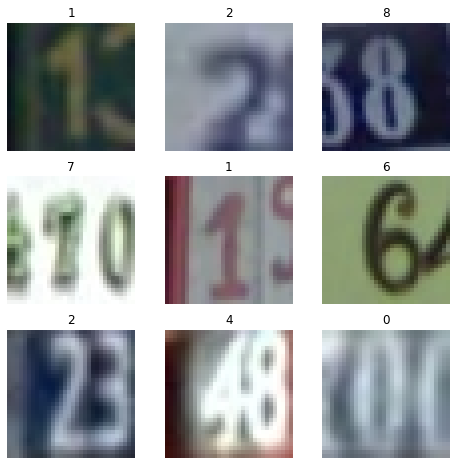

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(svhn_train_dataset), size=(1,)).item()
    img, label = svhn_train_dataset[sample_idx]
    img = img.permute(1, 2, 0)
    ax1 = figure.add_subplot(rows, cols, i)
    ax1.set_title(label)
    plt.axis("off")
    plt.imshow(img.squeeze())

plt.show()

## Creating 2d-array with all the tensors based on label

In [6]:
num_classes = len(mnist_train_dataset.classes)

mnist_idx_by_class = [np.where(mnist_train_dataset.targets == i)[0] for i in range(0, num_classes)]
mnist_idx_test_by_class = [np.where(mnist_test_dataset.targets == i)[0] for i in range(0, num_classes)]

svhn_idx_by_class = [np.where(svhn_train_dataset.labels == i)[0] for i in range(0, num_classes)]
svhn_idx_test_by_class = [np.where(svhn_test_dataset.labels == i)[0] for i in range(0, num_classes)]

## Inspecting same label images from the two datasets
*Here we can see the difference between the datasets, compared on the same number*

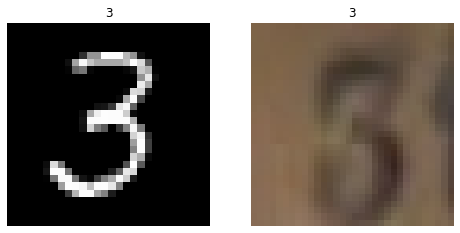

In [7]:
random_class = np.random.randint(0, num_classes)

mnist_idx = random.choice(mnist_idx_by_class[random_class])
svhn_idx = random.choice(svhn_idx_by_class[random_class])

figure = plt.figure(figsize=(8, 8))
mnist_img = mnist_train_dataset.data[mnist_idx]
svhn_img = svhn_train_dataset.data[svhn_idx]

ax = figure.add_subplot(1, 2, 1)
ax.set_title(random_class)
plt.axis("off")
plt.imshow(mnist_img.squeeze(), cmap="gray")
ax = figure.add_subplot(1, 2, 2)
ax.set_title(random_class)
plt.axis("off")
plt.imshow(svhn_img.transpose(1, 2, 0))

plt.show()



# Rewrite this based on what we end up using
## Visualizing the distribution of labels from both train splits
*As we can see the SVHN contains more images in total compared to the MNIST dataset. The distribution between the different
classes is also quite uneven. To overcome this we will reduce the amount of images per class to 6k.
The MNIST dataset generally has a quite even distribution of the digits and has a total of 60k images on the train split.
We will do no modification to this dataset*


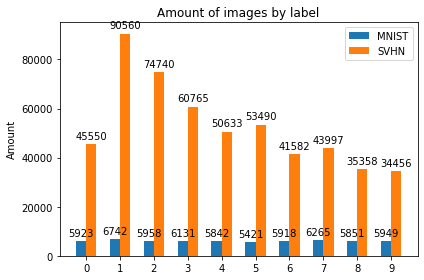

In [8]:
labels = np.arange(0, 10)
len_mnist = [len(x) for x in mnist_idx_by_class]
len_svhn = [len(x) for x in svhn_idx_by_class]

width = 0.3

fig, ax = plt.subplots()
rects1 = ax.bar(labels - width / 2, len_mnist, width, label='MNIST')
rects2 = ax.bar(labels + width / 2, len_svhn, width, label='SVHN')

ax.set_ylabel('Amount')
ax.set_title('Amount of images by label')
ax.set_xticks(labels, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

## Visualizing the distribution of labels from both test splits
*We can see that the distribution between the test splits are also quite uneven. To handle this
we will reduce the number of test images in SVHN to 1k.*

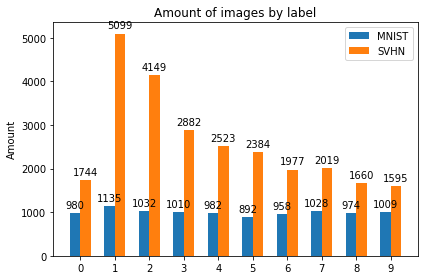

In [9]:
labels = np.arange(0, 10)
len_mnist = [len(x) for x in mnist_idx_test_by_class]
len_svhn = [len(x) for x in svhn_idx_test_by_class]

width = 0.3

fig, ax = plt.subplots()
rects1 = ax.bar(labels - width / 2, len_mnist, width, label='MNIST')
rects2 = ax.bar(labels + width / 2, len_svhn, width, label='SVHN')

ax.set_ylabel('Amount')
ax.set_title('Amount of images by label')
ax.set_xticks(labels, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()


# Data preprocessing - Exploration phase
*As we determined above, there is quite some difference between the datasets. In this section we will
try to do some preprocessing to bridge the gap between the two*

## Grayscale
*We will start by applying grayscale as this makes the image go from 3 channel to 1 channel. This is necessary as
the MNIST images is already 1 channel.*

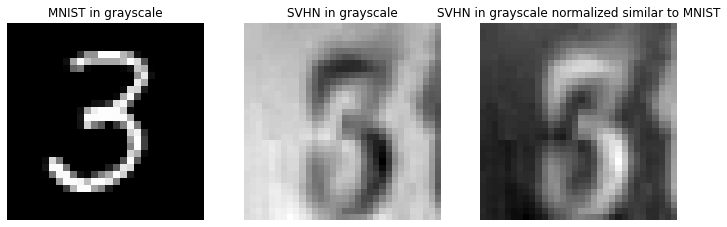

In [10]:
gray_svhn = T.Grayscale()(torch.from_numpy(svhn_img))

gray_svhn2 = gray_svhn

gray_svhn = torch.movedim(gray_svhn, 0, 2)

gray_svhn2 = gray_svhn2.detach().numpy()
gray_svhn2 = cv.normalize(gray_svhn2, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
gray_svhn2 = 255 - gray_svhn2

figure = plt.figure(figsize=(12, 8))
ax = figure.add_subplot(1, 3, 1)
plt.axis("off")
ax.set_title("MNIST in grayscale")
plt.imshow(mnist_img.squeeze(), cmap="gray")

ax = figure.add_subplot(1, 3, 2)
plt.axis("off")
ax.set_title("SVHN in grayscale")
plt.imshow(gray_svhn.squeeze(), cmap="gray")

ax = figure.add_subplot(1, 3, 3)
plt.axis("off")
ax.set_title("SVHN in grayscale normalized similar to MNIST")
plt.imshow(gray_svhn2.squeeze(), cmap="gray")

plt.show()


## Threshold
*Another technique we will try is thresholding the image. By doing this we will get a output image only
consisting of black and white. As we can see below, the threshold delivers some questionable results. Although
it is able to deliver only black and white, it still adds noise to the image.*

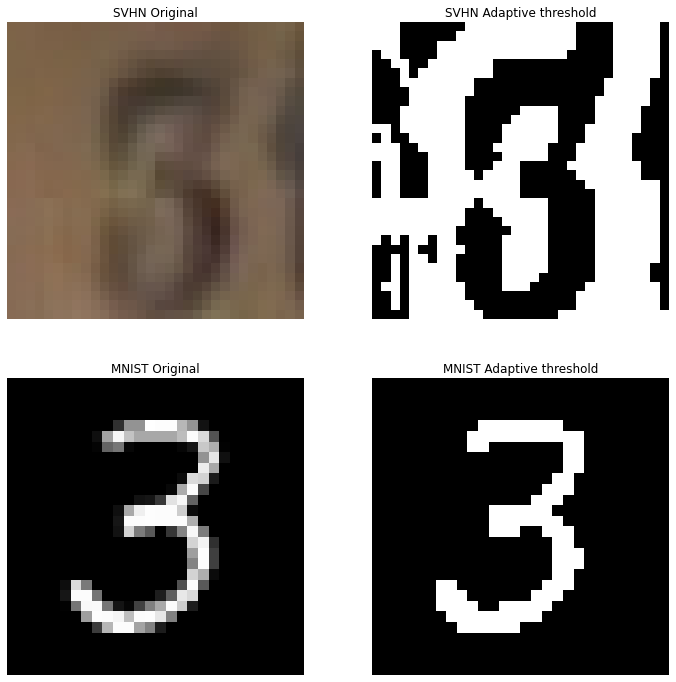

In [11]:
svhn = svhn_img.transpose(1, 2, 0)
mnist = mnist_img.detach().numpy()

svhn_grey = cv.cvtColor(svhn, cv.COLOR_BGR2GRAY)
svhn_grey = cv.normalize(svhn_grey, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
svhn_grey = svhn_grey.astype(np.uint8)

#Should find a good number for reduction on adaptive threshold, e.g. the last number
svhn_threshold = cv.adaptiveThreshold(svhn_grey, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 0)
#svhn_threshold = cv.bitwise_not(svhn_threshold)

#Threshold reduction number needs to be 0 on mnist
mnist = cv.normalize(mnist, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)
mnist = mnist.astype(np.uint8)
mnist_threshold = cv.adaptiveThreshold(mnist, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 0)

figure = plt.figure(figsize=(12, 12))

ax = figure.add_subplot(2, 2, 1)
ax.set_title("SVHN Original")
plt.axis("off")
plt.imshow(svhn, cmap="gray")

ax = figure.add_subplot(2, 2, 2)
ax.set_title("SVHN Adaptive threshold")
plt.axis("off")
plt.imshow(svhn_threshold, cmap="gray")

ax = figure.add_subplot(2, 2, 3)
ax.set_title("MNIST Original")
plt.axis("off")
plt.imshow(mnist, cmap="gray")

ax = figure.add_subplot(2, 2, 4)
ax.set_title("MNIST Adaptive threshold")
plt.axis("off")
plt.imshow(mnist_threshold, cmap="gray")

plt.show()

## Equalize Hist and CLAHE
*Last we will try equalize histogram and CLAHE + grayscale. We will first convert the images into grayscale
before applying the different techniques, leaving us with a 1 channel image.*

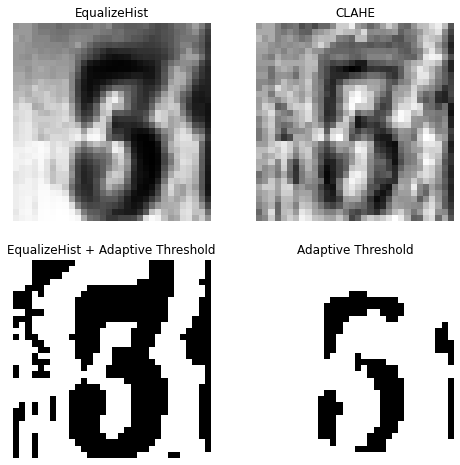

In [12]:
image = svhn

image = cv.normalize(image, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
image = image.astype(np.uint8)

image2 = image
image4 = image

image = cv.equalizeHist(image)
clahe = cv.createCLAHE(clipLimit=3., )
image2 = clahe.apply(image2)

image3 = cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2)
image4 = cv.adaptiveThreshold(image4, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 20)

figure = plt.figure(figsize=(8, 8))

ax = figure.add_subplot(2, 2, 1)
ax.set_title("EqualizeHist")
plt.axis("off")
plt.imshow(image.squeeze(), cmap="gray")
ax = figure.add_subplot(2, 2, 2)
ax.set_title("CLAHE")
plt.axis("off")
plt.imshow(image2.squeeze(), cmap="gray")
ax = figure.add_subplot(2, 2, 3)
ax.set_title("EqualizeHist + Adaptive Threshold")
plt.axis("off")
plt.imshow(image3.squeeze(), cmap="gray")
ax = figure.add_subplot(2, 2, 4)
ax.set_title("Adaptive Threshold")
plt.axis("off")
plt.imshow(image4.squeeze(), cmap="gray")


## Clearing up variables
*Upon ending the exploration we will empty some variables to reduce the load as much as possible*


In [13]:
del svhn_idx_by_class
del svhn_train_dataset
del mnist_idx_by_class
del mnist_train_dataset

# Defining the model
*Let's start with defining the different models that will be used for the training*

### Using CUDA if possible

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


## Defining the loss function
*The loss function used in this project is a contrastive loss. When two images is similar, the loss will
be low and high when the images are dissimilar. The margin in the loss function sets the limit for how
the distance of dissimilar images will be. If the distance is greater than the margin, the loss is set to zero
because the representations are already far enough apart. If the distance is less than the margin,
the loss is set to the difference between the distance and the margin, encouraging the network to
push the representations farther apart.*

In [15]:
class ContrastiveLoss(nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)

        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2)
            + label
            * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        ) / 2.0
        return loss_contrastive


def threshold_contrastive_loss(output1: torch.Tensor, output2: torch.Tensor, m: float):
    """dist > m --> 1 else 0"""
    euclidean_distance = F.pairwise_distance(output1, output2)
    threshold = euclidean_distance.clone()
    threshold.data.fill_(m)
    return (euclidean_distance > threshold).float()


## Transformations
*We define the transformations that we want to use on our images*

In [16]:
class ToNumpy:
    def __call__(self, sample):
        if len(sample.shape) == 2:
            sample = sample.unsqueeze(0)

        if isinstance(sample, torch.Tensor):
            sample = sample.numpy()
        return sample.transpose(1, 2, 0)


class Resize:
    def __call__(self, sample):
        return cv2.resize(sample, (28, 28))


class GrayScale:
    def __call__(self, sample):
        if len(sample.shape) < 3:
            return sample
        return cv2.cvtColor(sample, cv2.COLOR_RGB2GRAY)


class EqualizeHist:
    def __call__(self, sample):
        sample = cv.normalize(sample, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)
        sample = cv.equalizeHist(sample)
        if len(np.where(sample.flatten() > 200)[0]) > len(np.where(sample.flatten() < 200)[0]):
            sample = 255 - sample
        return sample


class CLAHE:
    def __call__(self, sample):
        sample = cv.normalize(sample, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)
        clahe = cv.createCLAHE(clipLimit=3., )
        sample = clahe.apply(sample)
        if len(np.where(sample.flatten() > 200)[0]) > len(np.where(sample.flatten() < 200)[0]):
            sample = 255 - sample
        return sample


class AdaptiveThreshold:
    def __call__(self, sample):
        sample = cv.normalize(sample, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)
        sample = cv.adaptiveThreshold(sample, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 10)
        if len(np.where(sample.flatten() > 200)[0]) > len(np.where(sample.flatten() < 200)[0]):
            sample = 255 - sample

        return sample


## Defining siamese network model
*Our model is based on the resnet architecture. We have slightly modified it to fit our needs of images
with only 1 channel instead of 3 channel*

In [17]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = torchvision.models.resnet18(pretrained=False)
        self.fc_in_features = self.cnn1.fc.in_features

        self.cnn1.conv1 = nn.Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
        self.cnn1 = nn.Sequential(*(list(self.cnn1.children())[:-1]))

        self.fc1 = nn.Sequential(
            nn.Linear(self.fc_in_features, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10),
        )

    def forward_once(self, x):
        # Forward pass
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2


## Non-siamese model
*Our non-siamese model is also based on the resnet18 architecture. Instead of using the same network
for both forward passes, we have two separate resnet18 networks for each input. One network will always handle input
from one dataset, and the other network will always handle the data from the remaining dataset.  We design the non-siamese
dataset such that MNIST input always will be the first and SVHN always will be second.*

In [18]:
class NonSiameseNetwork(nn.Module):
    def __init__(self):
        super(NonSiameseNetwork, self).__init__()

        #By design of the dataset input 1 will always be mnist and input 2 will always be svhn

        self.cnn1 = torchvision.models.resnet18(pretrained=False)
        self.fc_in_features = self.cnn1.fc.in_features
        self.cnn1.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
        self.cnn1 = nn.Sequential(*(list(self.cnn1.children())[:-1]))

        self.cnn2 = torchvision.models.resnet18(pretrained=False)
        self.cnn2.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
        self.cnn2 = nn.Sequential(*(list(self.cnn2.children())[:-1]))

        self.fc1 = nn.Sequential(
            nn.Linear(self.fc_in_features, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10),
        )

        self.fc2 = nn.Sequential(
            nn.Linear(self.fc_in_features, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10),
        )

    def forward_once(self, x):
        # Forward pass
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward_second(self, x):
        output = self.cnn2(x)
        output = output.view(output.size()[0], -1)
        output = self.fc2(output)
        return output

    def forward(self, input1, input2):
        # forward pass of mnist input
        output1 = self.forward_once(input1)
        # forward pass of svhn input
        output2 = self.forward_second(input2)
        return output1, output2


# Setting up the custom datasets


## The four possible dataset combinations

In [19]:
class DatasetType(Enum):
    MNIST = 1, #Only the MNIST dataset
    SVHN = 2, #Only the SVHN dataset
    BOTH = 3, #SVHN images will be paired with SVHN and MNIST images with MNIST
    MIX = 4 #SVHN and MNIST will be paired and mixed at random

## Siamese dataset
*The siamese dataset can be mixed based on the enum. It will preprocess the whole dataset based on
the transformation before creating the pairs. The pairs are created with both negative and positive samples,
meaning that we will have some pair of images where they are from the same class and some images
where the images are from different classes.*

In [20]:
class SiameseDataset(Dataset):
    def __init__(self, train: bool, dataset_type: DatasetType, transform=None):
        self.dataset_type = dataset_type
        self.transform = transform
        self.train = train

        # Numbers 0 to 9 as a total of 10 classes
        self.num_classes = 10

        # Unless the dataset is set to only SVHN we include the MNIST
        if self.dataset_type != DatasetType.SVHN:
            self.mnist = torchvision.datasets.MNIST("files", train=train, download=True)
            print("Preprocessing MNIST")
            self.mnist_preprocessed = list(map(self.transform, self.mnist.data))
            print("MNIST preprocessed")

        # Unless the dataset is set to only MNIST we include the SVHN
        if self.dataset_type != DatasetType.MNIST:
            self.svhn = torchvision.datasets.SVHN(root="data", split="extra" if train else "test", download=True)
            print("Preprocessing SVHN")
            self.svhn_preprocessed = list(map(self.transform, self.svhn.data))
            print("SVHN preprocessed")

        self.pairs = self.make_pairs()

    def __getitem__(self, index):
        img1_dataset, img1_index, img2_dataset, img2_index, matching = self.pairs[index]

        img1 = self.mnist_preprocessed[img1_index] if (img1_dataset == 0) else self.svhn_preprocessed[img1_index]
        img2 = self.mnist_preprocessed[img2_index] if (img2_dataset == 0) else self.svhn_preprocessed[img2_index]

        return img1, img2, matching

    def __len__(self):
        return len(self.pairs)

    def make_pairs(self):
        """
            Generating index pairs from images within the datasets.
            For each image one positive and one negative image pair is generated.
            If type is set to MIX it mixes pairs between MNIST and SVHN.
            If type is set to BOTH it uses images between MNIST and SVHN separately.
            If type is set to SVHN it uses only SVHN dataset.
            If type is set to MNIST it uses only MNIST dataset.
        """
        pairs = []

        if self.dataset_type == DatasetType.MNIST or self.dataset_type == DatasetType.BOTH:
            mnist_by_label = [np.where(self.mnist.targets == i)[0] for i in range(0, self.num_classes)]

            for label in range(len(mnist_by_label)):
                for anchor_image in mnist_by_label[label]:

                    pos_image = np.random.choice(mnist_by_label[label])
                    pairs.append([0, anchor_image, 0, pos_image, 0])

                    neg_label = np.random.randint(0, self.num_classes)
                    while neg_label == label:
                        neg_label = np.random.randint(0, self.num_classes)

                    neg_image = np.random.choice(mnist_by_label[neg_label])
                    pairs.append([0, anchor_image, 0, neg_image, 1])

        if self.dataset_type == DatasetType.SVHN or self.dataset_type == DatasetType.BOTH:
            svhn_by_label = [np.where(self.svhn.labels == i)[0] for i in range(0, self.num_classes)]
            for i in range(0, self.num_classes):
                limit = 6000 if self.train is True else 1000
                svhn_by_label[i] = svhn_by_label[i][0:limit]

            for label in range(len(svhn_by_label)):
                for anchor_image in svhn_by_label[label]:

                    pos_image = np.random.choice(svhn_by_label[label])

                    pairs.append([1, anchor_image, 1, pos_image, 0])

                    neg_label = np.random.randint(0, self.num_classes)
                    while neg_label == label:
                        neg_label = np.random.randint(0, self.num_classes)

                    neg_image = np.random.choice(svhn_by_label[neg_label])

                    pairs.append([1, anchor_image, 1, neg_image, 1])

        if self.dataset_type == DatasetType.MIX:
            datasets_by_label = [[np.where(self.mnist.targets == i)[0] for i in range(0, self.num_classes)],
                                 [np.where(self.svhn.labels == i)[0] for i in range(0, self.num_classes)]]
            for i in range(0, len(datasets_by_label[1])):
                limit = 6000 if self.train is True else 1000
                datasets_by_label[1][i] = datasets_by_label[1][i][0:limit]

            for dataset_index in range(len(datasets_by_label)):
                dataset_by_label = datasets_by_label[dataset_index]

                for label in range(len(dataset_by_label)):
                    for anchor_image in dataset_by_label[label]:

                        pos_dataset_index = np.random.randint(0, 2)
                        pos_image = np.random.choice(datasets_by_label[pos_dataset_index][label])

                        pairs.append([dataset_index, anchor_image, pos_dataset_index, pos_image, 0])

                        neg_dataset_index = np.random.randint(0, 2)
                        neg_label = np.random.randint(0, self.num_classes)
                        while neg_label == label:
                            neg_label = np.random.randint(0, self.num_classes)

                        neg_image = np.random.choice(datasets_by_label[neg_dataset_index][neg_label])

                        pairs.append([dataset_index, anchor_image, neg_dataset_index, neg_image, 1])

        return pairs

## Non-Siamese dataset
*The non-siamese will be preprocessed similarly to the siamese dataset. The pairs are created
in such a way that it will always be a MNIST image as the first image and a SVHN image in the second*

In [21]:
class NonSiameseDataset(Dataset):
    def __init__(self, train: bool, dataset_type: DatasetType, transform=None):
        self.transform = transform
        self.train = train

        # Numbers 0 to 9 as a total of 10 classes
        self.num_classes = 10

        self.mnist = torchvision.datasets.MNIST("files", train=train, download=True)
        print("Preprocessing MNIST")
        self.mnist_preprocessed = list(map(self.transform, self.mnist.data))
        print("MNIST preprocessed")

        self.svhn = torchvision.datasets.SVHN(root="data", split="extra" if train else "test", download=True)
        print("Preprocessing SVHN")
        self.svhn_preprocessed = list(map(self.transform, self.svhn.data))
        print("SVHN preprocessed")

        self.pairs = self.make_pairs()

    def __getitem__(self, index):
        img1_index, img2_index, matching = self.pairs[index]

        img1 = self.mnist_preprocessed[img1_index]
        img2 = self.svhn_preprocessed[img2_index]

        return img1, img2, matching

    def __len__(self):
        return len(self.pairs)

    def make_pairs(self):
        """
            Generating index pairs from images within the datasets.
            For each image one positive and one negative image pair is generated.
        """
        pairs = []
        datasets_by_label = [[np.where(self.mnist.targets == i)[0] for i in range(0, self.num_classes)],
                             [np.where(self.svhn.labels == i)[0] for i in range(0, self.num_classes)]]

        for i in range(0, len(datasets_by_label[1])):
            limit = 6000 if self.train is True else 1000
            datasets_by_label[1][i] = datasets_by_label[1][i][0:6000]

        for dataset_index in range(len(datasets_by_label)):
            dataset_by_label = datasets_by_label[dataset_index]

            for label in range(len(dataset_by_label)):
                for anchor_image in dataset_by_label[label]:

                    other_dataset = abs(dataset_index - 1)
                    pos_image = np.random.choice(datasets_by_label[other_dataset][label])

                    neg_label = np.random.randint(0, self.num_classes)
                    while neg_label == label:
                        neg_label = np.random.randint(0, self.num_classes)

                    neg_image = np.random.choice(datasets_by_label[other_dataset][neg_label])

                    if dataset_index == 0:
                        pairs.append([anchor_image, pos_image, 0])
                        pairs.append([anchor_image, neg_image, 1])
                    else:
                        pairs.append([pos_image, anchor_image, 0])
                        pairs.append([neg_label, anchor_image, 1])

        return pairs

## Train logic

In [22]:
def reset_weights(m):
    """
    Try resetting model weights to avoid
    weight leakage. Experienced this when using k-fold
    """
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            # print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()


def train(model, optimizer, criterion, dataloader, device):
    model.train()

    # If image pair has distance above this value they are considered as dissimilar
    binary_threshold = 1.

    loss = []
    correct = 0
    total = 0.
    for img1, img2, label in dataloader:
        optimizer.zero_grad()

        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        output1, output2 = model(img1, img2)

        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        loss.append(loss_contrastive.item())

        output_label = threshold_contrastive_loss(output1, output2, binary_threshold).to(device)
        total += len(label)
        correct += (output_label == label).sum().item()

    loss = np.array(loss)
    return loss.mean() / len(dataloader), correct / total


def save_model(model, name):
    model.eval()
    # Input to the model
    example1 = torch.randn(1, 1, 28, 28)
    example2 = torch.randn(1, 1, 28, 28)
    traced_script_module = torch.jit.trace(model.cpu(), (example1, example2))
    torch.jit.save(traced_script_module, name)
    print(f"Saved model with name: {name}")


def validate(model, criterion, dataloader, device):
    model.eval()

    # If image pair has distance above this value they are considered as dissimilar
    binary_threshold = 1.

    loss = []
    correct = 0
    total = 0.
    with torch.no_grad():
        for img1, img2, label in dataloader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)

            loss_contrastive = criterion(output1, output2, label)
            loss.append(loss_contrastive.item())

            output_label = threshold_contrastive_loss(output1, output2, binary_threshold).to(device)
            total += len(label)
            correct += (output_label == label).sum().item()

        loss = np.array(loss)
    return loss.mean() / len(dataloader), correct / total


def train_pipeline(epochs, k_fold, batch_size, train_dataset, lr, device, num_workers, model):
    contrastive_loss = ContrastiveLoss()
    best_model = ""

    for fold, (train_idx, val_idx) in enumerate(k_fold.split(train_dataset)):

        # Creating val loader and train loader based on current fold split
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler,
                                      num_workers=num_workers)
        val_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_subsampler,
                                    num_workers=num_workers)

        net = model()
        net.apply(reset_weights)
        net = net.to(device)

        adam = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.001)

        rounds_without_improvement = 0
        best_loss = float('inf')
        best_epoch = 0

        print(f"--FOLD {fold + 1}--\n")
        for epoch in range(epochs):
            print(f"--EPOCH {epoch + 1}--")

            train_loss, train_acc = train(model=net, optimizer=adam, criterion=contrastive_loss, device=device,
                                          dataloader=train_dataloader)
            print(f"Train loss {train_loss:.5f}, Train acc {train_acc:.5f}")

            val_loss, val_acc = validate(model=net, criterion=contrastive_loss, device=device,
                                         dataloader=val_dataloader)
            print(f"Val loss {val_loss:.5f}, Val acc {val_acc:.5f}")

            # Saving best model so far
            if val_loss < best_loss:
                best_loss = val_loss
                best_epoch = epoch
                best_model = copy.deepcopy(net)
                rounds_without_improvement = 0
            else:
                rounds_without_improvement += 1

            # Early stopping if model cease to improve
            if rounds_without_improvement > 3:
                break

        save_model(model=best_model,
                   name=f"fold{fold + 1}-epoch{best_epoch + 1}-transforms{random.randint(0, 10000)}.pt")

    return best_model

## Test logic

In [23]:
def test_pipeline(test_dataset, num_workers, model, batch_size, device):
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    # Load from disk based on the model name
    if isinstance(model, str):
        model = torch.jit.load(f"{model}.pt")
    model = model.to(device)

    # Array that keeps track on euclidean distance based on true label
    res = [[], []]
    count = 1

    # Classify images as different if above this value
    binary_threshold = 1.

    # Keeping track num of correct predictions and total predictions
    correct = 0
    total = 0.

    with torch.no_grad():
        for img1, img2, label in test_dataloader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            # Generating output for current batch
            output1, output2 = model(img1, img2)

            # Generating similar/dissimilar predictions based on output and distance threshold
            output_label = threshold_contrastive_loss(output1, output2, binary_threshold).to(device)

            total += len(label)
            correct += (output_label == label).sum().item()

            # Add distance to collection based on true label between the images
            for i in range(len(output1)):
                res[label[i]].append(F.pairwise_distance(output1[i], output2[i]).item())

            # Plot test examples and display distance and true label
            if count < 10:
                figure = plt.figure(figsize=(4, 4))
                figure.suptitle(f'Image no.{count}', fontsize=16)

                ax = figure.add_subplot(1, 2, 1)
                ax.set_title("Img1")
                plt.axis("off")
                plt.imshow(img1[0].cpu().squeeze(), cmap="gray")
                ax = figure.add_subplot(1, 2, 2)
                ax.set_title("Img2")
                plt.axis("off")
                plt.imshow(img2[0].cpu().squeeze(), cmap="gray")

                plt.show()

                print(f"Image no.{count}")
                if label[0].cpu() == torch.FloatTensor([[0]]):
                    caption = "Same numbers"
                else:
                    caption = "Different numbers"

                print(f"Correct label: '{caption}'")
                print(F.pairwise_distance(output1[0], output2[0]).item())
                print()

            count += 1

        # Print mean and standard deviation based on distance from the different categories
        print("\nImages with same number")
        print(f"Mean: {torch.mean(torch.tensor(res[0]))}")
        print(f"Std: {torch.std(torch.tensor(res[0]))}\n")

        print("Images with different number")
        print(f"Mean: {torch.mean(torch.tensor(res[1]))}")
        print(f"Std: {torch.std(torch.tensor(res[1]))}\n")

        print(f"Accuracy {correct / total}")
        fig = plt.figure(1, figsize=(9, 6))
        ax = fig.add_subplot(111)
        ax.boxplot(res)
        plt.show()

# Experiments

*We will conduct two main experiments, with two different preprocessing in both. In the first part,
we will use a siamese model and the siamese dataset. We will try all 4 different combinations of the dataset
with both preprocessing. In the second part we will use the non-siamese model and dataset with both preprocessings.*

In [24]:
class Pipelines:
    def __init__(self, k_fold_splits, batch_size, lr, epochs, transform, device, num_workers, siamese: bool):
        self.k_fold = KFold(n_splits=k_fold_splits, shuffle=True)
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.transform = transform
        self.device = device
        self.num_workers = num_workers

        if siamese:
            self.dataset = SiameseDataset
            self.model = SiameseNetwork
        else:
            self.dataset = NonSiameseDataset
            self.model = NonSiameseNetwork

    def mnist_svhn_mix_pipeline(self):
        print("Starting mnist-svhn-mix pipeline")

        train_dataset = self.dataset(train=True, dataset_type=DatasetType.MIX, transform=self.transform)
        model = train_pipeline(epochs=self.epochs, k_fold=self.k_fold, batch_size=self.batch_size,
                               train_dataset=train_dataset, lr=self.lr, device=self.device,
                               num_workers=self.num_workers, model=self.model)

        del train_dataset

        test_dataset = self.dataset(train=False, dataset_type=DatasetType.MIX, transform=self.transform)
        test_pipeline(test_dataset=test_dataset, batch_size=self.batch_size, device=self.device,
                      num_workers=self.num_workers,
                      model=model)

    def mnist_svhn_pipeline(self):
        print("Starting mnist-svhn pipeline")
        train_dataset = self.dataset(train=True, dataset_type=DatasetType.BOTH, transform=self.transform)
        model = train_pipeline(epochs=self.epochs, k_fold=self.k_fold, batch_size=self.batch_size,
                               train_dataset=train_dataset, lr=self.lr, device=device,
                               num_workers=self.num_workers, model=self.model)

        del train_dataset

        test_dataset = self.dataset(train=False, dataset_type=DatasetType.BOTH, transform=self.transform)
        test_pipeline(test_dataset=test_dataset, batch_size=self.batch_size, device=self.device,
                      num_workers=self.num_workers,
                      model=model)

    def mnist_pipeline(self):
        print("Starting mnist pipeline")
        train_dataset = self.dataset(train=True, dataset_type=DatasetType.MNIST, transform=self.transform)
        model = train_pipeline(epochs=self.epochs, k_fold=self.k_fold, batch_size=self.batch_size,
                               train_dataset=train_dataset, lr=self.lr, device=device,
                               num_workers=self.num_workers, model=self.model)

        del train_dataset

        test_dataset = self.dataset(train=False, dataset_type=DatasetType.MNIST, transform=self.transform)
        test_pipeline(test_dataset=test_dataset, batch_size=self.batch_size, device=self.device,
                      num_workers=self.num_workers,
                      model=model)

    def svhn_pipeline(self):
        print("Starting svhn pipeline")
        train_dataset = self.dataset(train=True, dataset_type=DatasetType.SVHN, transform=self.transform)
        model = train_pipeline(epochs=self.epochs, k_fold=self.k_fold, batch_size=self.batch_size,
                               train_dataset=train_dataset, lr=self.lr, device=device,
                               num_workers=self.num_workers, model=self.model)

        del train_dataset

        test_dataset = self.dataset(train=False, dataset_type=DatasetType.SVHN, transform=self.transform)
        test_pipeline(test_dataset=test_dataset, batch_size=self.batch_size, device=self.device,
                      num_workers=self.num_workers,
                      model=model)

    def all_pipelines(self):
        self.mnist_svhn_mix_pipeline()
        self.mnist_svhn_pipeline()
        self.mnist_pipeline()
        self.svhn_pipeline()


Running config 1 pipeline
Starting mnist-svhn-mix pipeline


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting files/MNIST/raw/train-images-idx3-ubyte.gz to files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting files/MNIST/raw/train-labels-idx1-ubyte.gz to files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting files/MNIST/raw/t10k-images-idx3-ubyte.gz to files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting files/MNIST/raw/t10k-labels-idx1-ubyte.gz to files/MNIST/raw

Preprocessing MNIST
MNIST preprocessed
Using downloaded and verified file: data/extra_32x32.mat
Preprocessing SVHN
SVHN preprocessed
--FOLD 1--

--EPOCH 1--
Train loss 0.00115, Train acc 0.85609
Val loss 0.00188, Val acc 0.95017
--EPOCH 2--
Train loss 0.00037, Train acc 0.96142
Val loss 0.00153, Val acc 0.96150
--EPOCH 3--
Train loss 0.00029, Train acc 0.96902
Val loss 0.00134, Val acc 0.96475
--EPOCH 4--
Train loss 0.00026, Train acc 0.97158
Val loss 0.00127, Val acc 0.96367
--EPOCH 5--
Train loss 0.00026, Train acc 0.97222
Val loss 0.00128, Val acc 0.96513
--EPOCH 6--
Train loss 0.00023, Train acc 0.97518
Val loss 0.00129, Val acc 0.96246
--EPOCH 7--
Train loss 0.00023, Train acc 0.97464
Val loss 0.00116, Val acc 0.96683
--EPOCH 8--
Train loss 0.00022, Train acc 0.97635
Val loss 0.00106, Val acc 0.97033
--EPOCH 9--
Train loss 0.00021, Train acc 0.97649
Val loss 0.00113, Val acc 0.96740
--EPOCH 10--
Train loss 0.

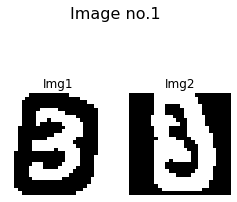

Image no.1
Correct label: 'Same numbers'
0.048704370856285095



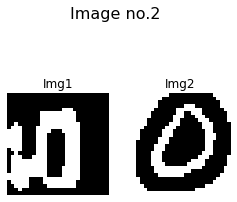

Image no.2
Correct label: 'Same numbers'
0.08277493715286255



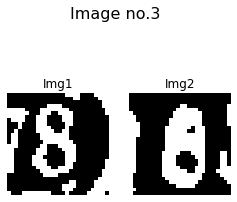

Image no.3
Correct label: 'Same numbers'
1.5738937854766846



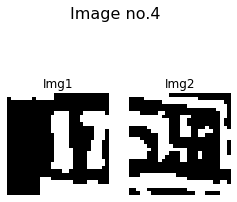

Image no.4
Correct label: 'Different numbers'
1.9652807712554932



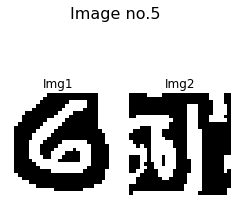

Image no.5
Correct label: 'Same numbers'
1.816470742225647



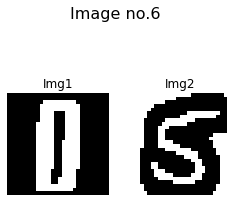

Image no.6
Correct label: 'Different numbers'
2.302072286605835



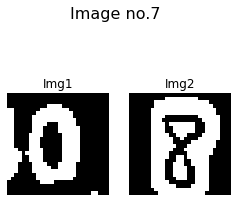

Image no.7
Correct label: 'Different numbers'
1.8956924676895142



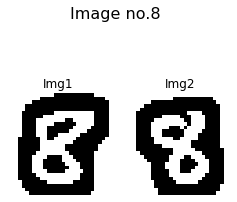

Image no.8
Correct label: 'Same numbers'
0.01737549528479576



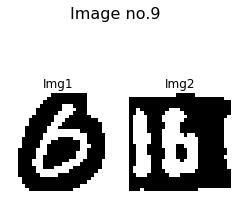

Image no.9
Correct label: 'Same numbers'
0.034008052200078964


Images with same number
Mean: 0.3227247893810272
Std: 0.5322170257568359

Images with different number
Mean: 1.9730361700057983
Std: 0.3507847785949707

Accuracy 0.925275


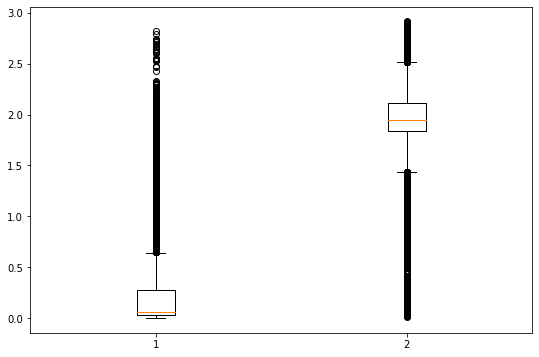

Starting mnist-svhn pipeline
Preprocessing MNIST
MNIST preprocessed
Using downloaded and verified file: data/extra_32x32.mat
Preprocessing SVHN
SVHN preprocessed
--FOLD 1--

--EPOCH 1--
Train loss 0.00104, Train acc 0.86996
Val loss 0.00172, Val acc 0.95337
--EPOCH 2--
Train loss 0.00036, Train acc 0.96255
Val loss 0.00159, Val acc 0.95829
--EPOCH 3--
Train loss 0.00029, Train acc 0.96904
Val loss 0.00130, Val acc 0.96371
--EPOCH 4--
Train loss 0.00026, Train acc 0.97184
Val loss 0.00122, Val acc 0.96646
--EPOCH 5--
Train loss 0.00025, Train acc 0.97302
Val loss 0.00163, Val acc 0.95265
--EPOCH 6--
Train loss 0.00023, Train acc 0.97403
Val loss 0.00115, Val acc 0.96798
--EPOCH 7--
Train loss 0.00022, Train acc 0.97545
Val loss 0.00132, Val acc 0.96029
--EPOCH 8--
Train loss 0.00021, Train acc 0.97641
Val loss 0.00122, Val acc 0.96375
--EPOCH 9--
Train loss 0.00021, Train acc 0.97681
Val loss 0.00102, Val acc 0.97031
--EPOCH 10--
Train loss 0.00021, Train acc 0.97658
Val loss 0.00095, V

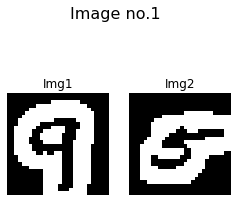

Image no.1
Correct label: 'Different numbers'
1.9706519842147827



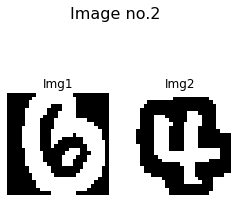

Image no.2
Correct label: 'Different numbers'
1.9250057935714722



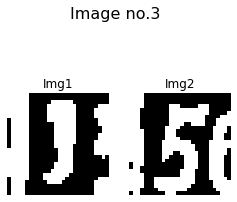

Image no.3
Correct label: 'Different numbers'
1.9165738821029663



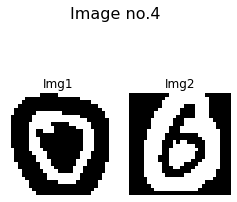

Image no.4
Correct label: 'Different numbers'
1.847913384437561



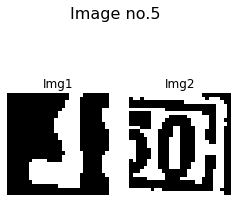

Image no.5
Correct label: 'Different numbers'
2.120789051055908



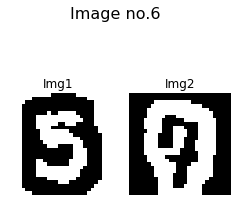

Image no.6
Correct label: 'Different numbers'
2.7960987091064453



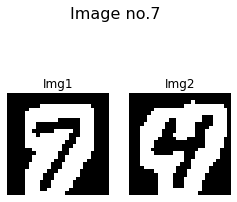

Image no.7
Correct label: 'Different numbers'
1.9273979663848877



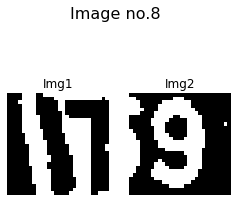

Image no.8
Correct label: 'Different numbers'
1.9698368310928345



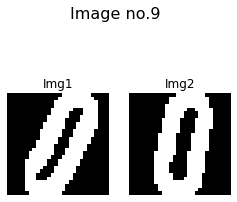

Image no.9
Correct label: 'Same numbers'
0.04058682546019554


Images with same number
Mean: 0.26962894201278687
Std: 0.5070976614952087

Images with different number
Mean: 2.0196213722229004
Std: 0.40526410937309265

Accuracy 0.935975


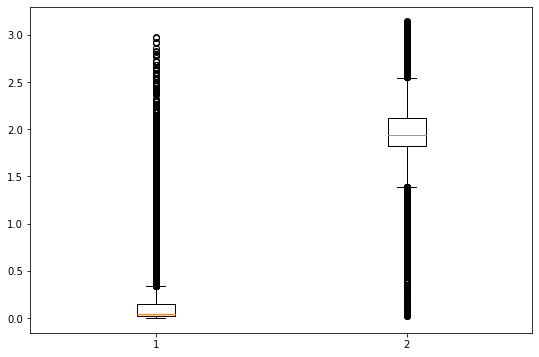

Starting mnist pipeline
Preprocessing MNIST
MNIST preprocessed
--FOLD 1--

--EPOCH 1--
Train loss 0.00183, Train acc 0.89401
Val loss 0.00216, Val acc 0.98050
--EPOCH 2--
Train loss 0.00032, Train acc 0.98714
Val loss 0.00274, Val acc 0.96337
--EPOCH 3--
Train loss 0.00021, Train acc 0.99047
Val loss 0.00111, Val acc 0.98667
--EPOCH 4--
Train loss 0.00019, Train acc 0.99114
Val loss 0.00169, Val acc 0.97617
--EPOCH 5--
Train loss 0.00017, Train acc 0.99180
Val loss 0.00109, Val acc 0.98454
--EPOCH 6--
Train loss 0.00017, Train acc 0.99160
Val loss 0.00105, Val acc 0.98796
--EPOCH 7--
Train loss 0.00016, Train acc 0.99205
Val loss 0.00192, Val acc 0.97242
--EPOCH 8--
Train loss 0.00016, Train acc 0.99190
Val loss 0.00074, Val acc 0.98971
--EPOCH 9--
Train loss 0.00014, Train acc 0.99289
Val loss 0.00103, Val acc 0.98538
--EPOCH 10--
Train loss 0.00014, Train acc 0.99271
Val loss 0.00090, Val acc 0.98679
Saved model with name: fold1-epoch8-transforms1587.pt
--FOLD 2--

--EPOCH 1--
Train 

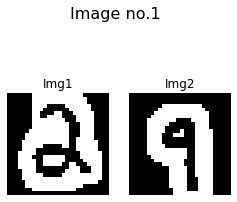

Image no.1
Correct label: 'Different numbers'
2.61199688911438



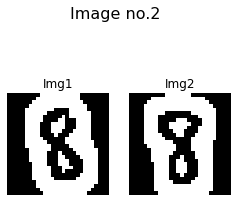

Image no.2
Correct label: 'Same numbers'
0.015573288314044476



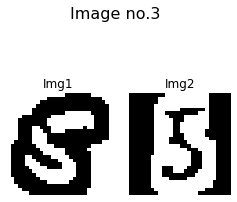

Image no.3
Correct label: 'Same numbers'
0.30688390135765076



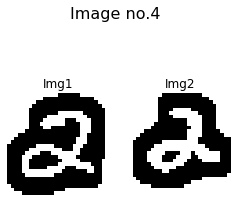

Image no.4
Correct label: 'Same numbers'
0.032104358077049255



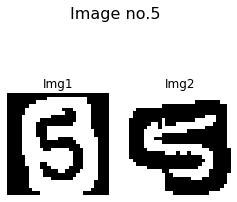

Image no.5
Correct label: 'Same numbers'
0.04875165969133377



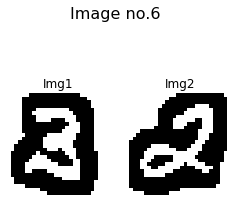

Image no.6
Correct label: 'Different numbers'
1.699668049812317



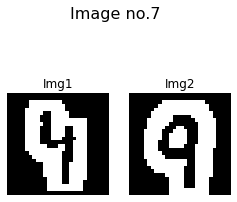

Image no.7
Correct label: 'Different numbers'
1.3308417797088623



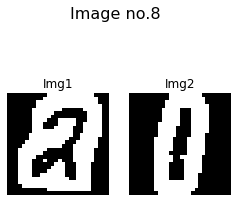

Image no.8
Correct label: 'Different numbers'
2.124152898788452



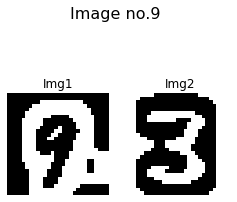

Image no.9
Correct label: 'Different numbers'
2.3427481651306152


Images with same number
Mean: 0.1129136011004448
Std: 0.25925159454345703

Images with different number
Mean: 2.279672384262085
Std: 0.4668046534061432

Accuracy 0.9864


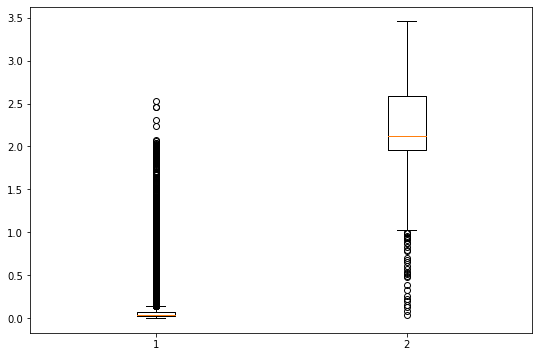

Starting svhn pipeline
Using downloaded and verified file: data/extra_32x32.mat
Preprocessing SVHN
SVHN preprocessed
--FOLD 1--

--EPOCH 1--
Train loss 0.00425, Train acc 0.69125
Val loss 0.00882, Val acc 0.86392
--EPOCH 2--
Train loss 0.00156, Train acc 0.91521
Val loss 0.00484, Val acc 0.93508
--EPOCH 3--
Train loss 0.00095, Train acc 0.95251
Val loss 0.00398, Val acc 0.95292
--EPOCH 4--
Train loss 0.00068, Train acc 0.96520
Val loss 0.00343, Val acc 0.95296
--EPOCH 5--
Train loss 0.00059, Train acc 0.96874
Val loss 0.00359, Val acc 0.94596
--EPOCH 6--
Train loss 0.00053, Train acc 0.97198
Val loss 0.00287, Val acc 0.96008
--EPOCH 7--
Train loss 0.00050, Train acc 0.97329
Val loss 0.00273, Val acc 0.96321
--EPOCH 8--
Train loss 0.00047, Train acc 0.97472
Val loss 0.00285, Val acc 0.95892
--EPOCH 9--
Train loss 0.00043, Train acc 0.97668
Val loss 0.00242, Val acc 0.96546
--EPOCH 10--
Train loss 0.00041, Train acc 0.97822
Val loss 0.00320, Val acc 0.95150
Saved model with name: fold1-e

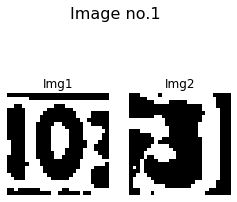

Image no.1
Correct label: 'Different numbers'
2.942243814468384



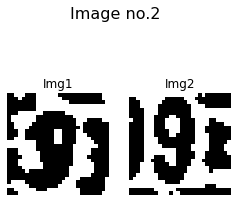

Image no.2
Correct label: 'Same numbers'
0.6273406147956848



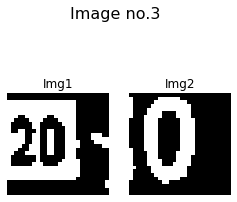

Image no.3
Correct label: 'Same numbers'
0.029250621795654297



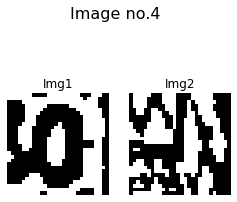

Image no.4
Correct label: 'Different numbers'
1.746880292892456



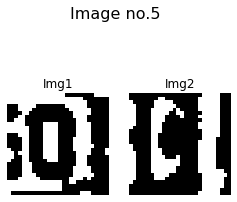

Image no.5
Correct label: 'Same numbers'
1.78331458568573



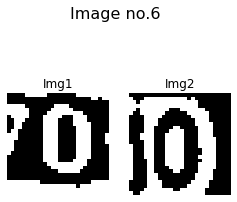

Image no.6
Correct label: 'Same numbers'
0.10600017011165619



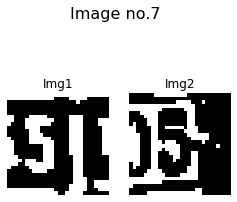

Image no.7
Correct label: 'Same numbers'
1.1159478425979614



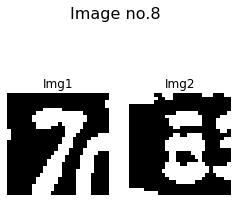

Image no.8
Correct label: 'Different numbers'
2.9130892753601074



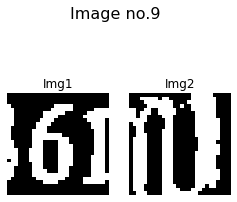

Image no.9
Correct label: 'Different numbers'
1.0097993612289429


Images with same number
Mean: 0.48018261790275574
Std: 0.6266651749610901

Images with different number
Mean: 1.9699753522872925
Std: 0.4975288212299347

Accuracy 0.8802


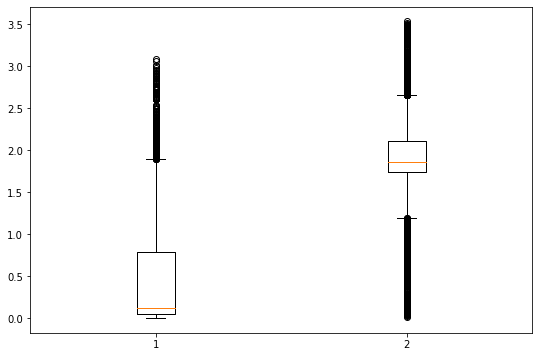

In [25]:
first_config = Pipelines(
    k_fold_splits=5,
    batch_size=1024,
    lr=0.001,
    epochs=10,
    transform=torchvision.transforms.Compose([
        ToNumpy(),
        Resize(),
        GrayScale(),
        AdaptiveThreshold(),
        ToTensor(),
    ]),
    device=device,
    num_workers=1,
    siamese=True
)

print("Running config 1 pipeline")
first_config.all_pipelines()

Running config 2 pipeline
Starting mnist-svhn-mix pipeline
Preprocessing MNIST
MNIST preprocessed
Using downloaded and verified file: data/extra_32x32.mat
Preprocessing SVHN
SVHN preprocessed
--FOLD 1--

--EPOCH 1--
Train loss 0.00137, Train acc 0.84233
Val loss 0.00191, Val acc 0.94706
--EPOCH 2--
Train loss 0.00033, Train acc 0.96498
Val loss 0.00137, Val acc 0.96325
--EPOCH 3--
Train loss 0.00024, Train acc 0.97491
Val loss 0.00098, Val acc 0.97256
--EPOCH 4--
Train loss 0.00021, Train acc 0.97715
Val loss 0.00109, Val acc 0.96737
--EPOCH 5--
Train loss 0.00019, Train acc 0.97923
Val loss 0.00086, Val acc 0.97525
--EPOCH 6--
Train loss 0.00018, Train acc 0.98013
Val loss 0.00100, Val acc 0.97113
--EPOCH 7--
Train loss 0.00018, Train acc 0.98004
Val loss 0.00084, Val acc 0.97667
--EPOCH 8--
Train loss 0.00017, Train acc 0.98126
Val loss 0.00105, Val acc 0.96967
--EPOCH 9--
Train loss 0.00017, Train acc 0.98108
Val loss 0.00083, Val acc 0.97610
--EPOCH 10--
Train loss 0.00017, Train a

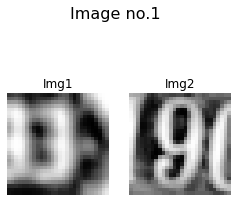

Image no.1
Correct label: 'Different numbers'
1.752027988433838



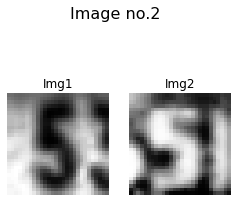

Image no.2
Correct label: 'Same numbers'
0.022097701206803322



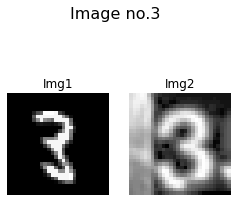

Image no.3
Correct label: 'Same numbers'
0.03299155458807945



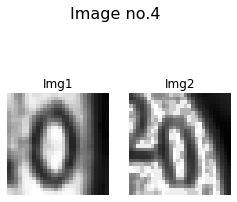

Image no.4
Correct label: 'Same numbers'
0.03077627904713154



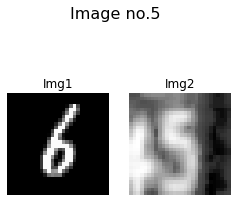

Image no.5
Correct label: 'Different numbers'
1.8588467836380005



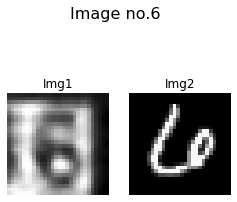

Image no.6
Correct label: 'Same numbers'
0.016554653644561768



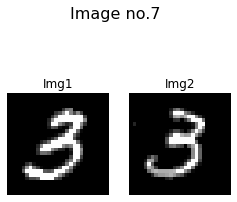

Image no.7
Correct label: 'Same numbers'
0.010676625184714794



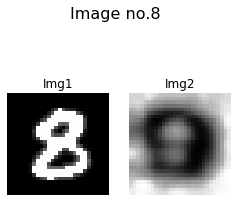

Image no.8
Correct label: 'Different numbers'
1.6346992254257202



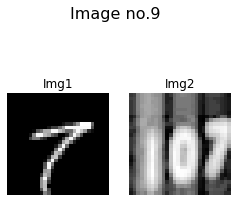

Image no.9
Correct label: 'Different numbers'
2.709446668624878


Images with same number
Mean: 0.2620285749435425
Std: 0.497920960187912

Images with different number
Mean: 1.9987820386886597
Std: 0.37736234068870544

Accuracy 0.93815


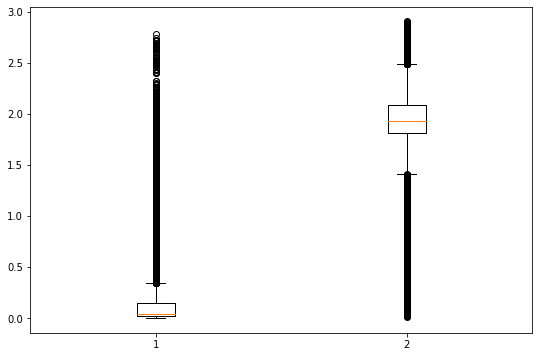

Starting mnist-svhn pipeline
Preprocessing MNIST
MNIST preprocessed
Using downloaded and verified file: data/extra_32x32.mat
Preprocessing SVHN
SVHN preprocessed
--FOLD 1--

--EPOCH 1--
Train loss 0.00119, Train acc 0.85141
Val loss 0.00194, Val acc 0.95031
--EPOCH 2--
Train loss 0.00035, Train acc 0.96445
Val loss 0.00127, Val acc 0.96667
--EPOCH 3--
Train loss 0.00025, Train acc 0.97319
Val loss 0.00122, Val acc 0.96633
--EPOCH 4--
Train loss 0.00023, Train acc 0.97601
Val loss 0.00096, Val acc 0.97740
--EPOCH 5--
Train loss 0.00020, Train acc 0.97844
Val loss 0.00097, Val acc 0.97358
--EPOCH 6--
Train loss 0.00019, Train acc 0.97889
Val loss 0.00090, Val acc 0.97527
--EPOCH 7--
Train loss 0.00018, Train acc 0.97986
Val loss 0.00089, Val acc 0.97537
--EPOCH 8--
Train loss 0.00018, Train acc 0.98056
Val loss 0.00079, Val acc 0.97852
--EPOCH 9--
Train loss 0.00017, Train acc 0.98072
Val loss 0.00084, Val acc 0.97708
--EPOCH 10--
Train loss 0.00017, Train acc 0.98047
Val loss 0.00097, V

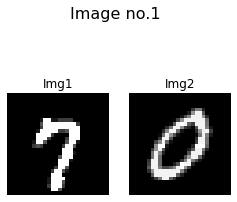

Image no.1
Correct label: 'Different numbers'
3.293659210205078



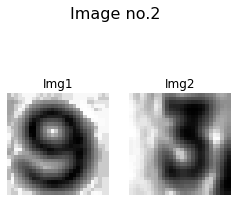

Image no.2
Correct label: 'Different numbers'
2.1084136962890625



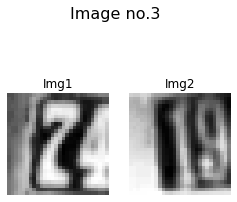

Image no.3
Correct label: 'Different numbers'
1.9622398614883423



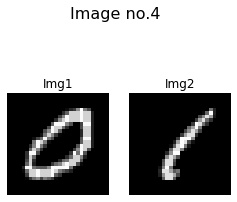

Image no.4
Correct label: 'Different numbers'
2.1558127403259277



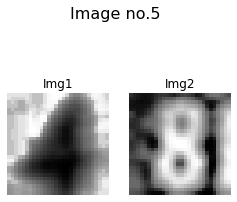

Image no.5
Correct label: 'Different numbers'
2.0333118438720703



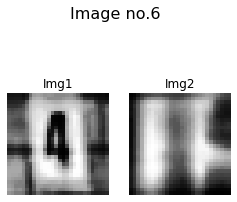

Image no.6
Correct label: 'Different numbers'
1.6180094480514526



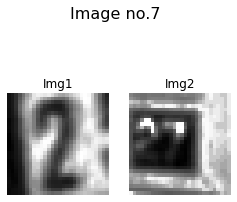

Image no.7
Correct label: 'Different numbers'
1.6178202629089355



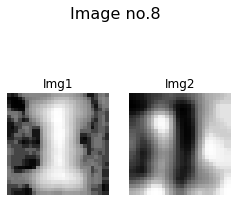

Image no.8
Correct label: 'Same numbers'
0.03530558571219444



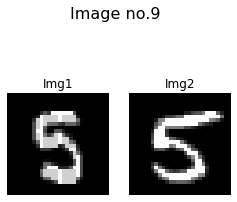

Image no.9
Correct label: 'Same numbers'
0.06253840029239655


Images with same number
Mean: 0.24869081377983093
Std: 0.4586581289768219

Images with different number
Mean: 2.0301454067230225
Std: 0.44181275367736816

Accuracy 0.946325


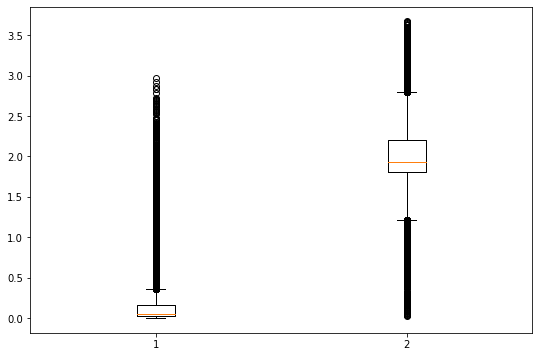

Starting mnist pipeline
Preprocessing MNIST
MNIST preprocessed
--FOLD 1--

--EPOCH 1--
Train loss 0.00168, Train acc 0.92792
Val loss 0.00165, Val acc 0.98388
--EPOCH 2--
Train loss 0.00025, Train acc 0.99009
Val loss 0.00087, Val acc 0.99075
--EPOCH 3--
Train loss 0.00015, Train acc 0.99401
Val loss 0.00089, Val acc 0.98825
--EPOCH 4--
Train loss 0.00013, Train acc 0.99399
Val loss 0.00072, Val acc 0.98987
--EPOCH 5--
Train loss 0.00011, Train acc 0.99510
Val loss 0.00070, Val acc 0.99229
--EPOCH 6--
Train loss 0.00012, Train acc 0.99458
Val loss 0.00057, Val acc 0.99271
--EPOCH 7--
Train loss 0.00010, Train acc 0.99525
Val loss 0.00067, Val acc 0.99146
--EPOCH 8--
Train loss 0.00012, Train acc 0.99398
Val loss 0.00061, Val acc 0.99158
--EPOCH 9--
Train loss 0.00011, Train acc 0.99464
Val loss 0.00112, Val acc 0.98400
--EPOCH 10--
Train loss 0.00010, Train acc 0.99506
Val loss 0.00045, Val acc 0.99396
Saved model with name: fold1-epoch10-transforms9928.pt
--FOLD 2--

--EPOCH 1--
Train

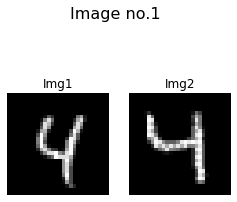

Image no.1
Correct label: 'Same numbers'
0.016588296741247177



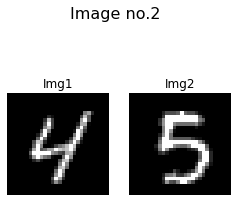

Image no.2
Correct label: 'Different numbers'
2.8543543815612793



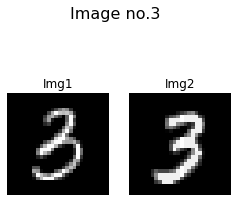

Image no.3
Correct label: 'Same numbers'
0.02867148257791996



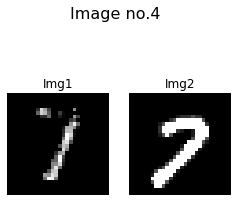

Image no.4
Correct label: 'Same numbers'
1.55782151222229



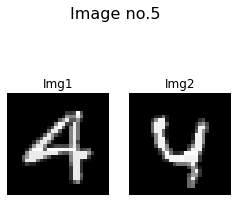

Image no.5
Correct label: 'Same numbers'
0.01885879598557949



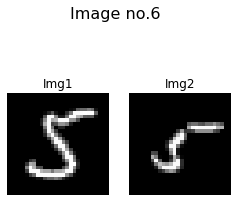

Image no.6
Correct label: 'Same numbers'
0.02448965609073639



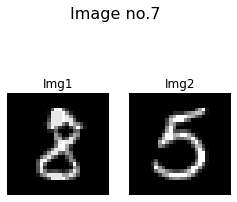

Image no.7
Correct label: 'Different numbers'
3.003326654434204



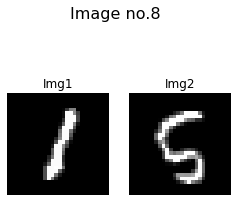

Image no.8
Correct label: 'Different numbers'
2.4472908973693848



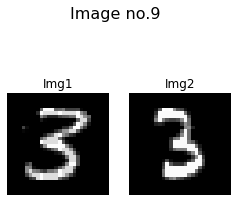

Image no.9
Correct label: 'Same numbers'
0.02148631028831005


Images with same number
Mean: 0.0902354046702385
Std: 0.22687886655330658

Images with different number
Mean: 2.2278807163238525
Std: 0.3927655816078186

Accuracy 0.98945


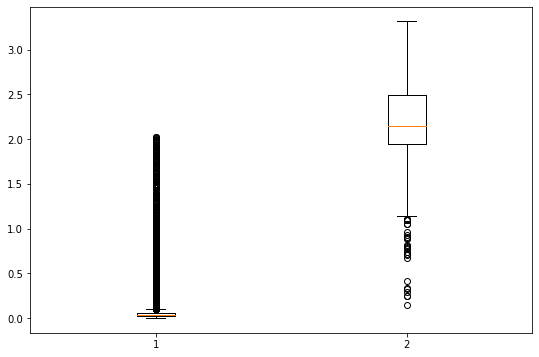

Starting svhn pipeline
Using downloaded and verified file: data/extra_32x32.mat
Preprocessing SVHN
SVHN preprocessed
--FOLD 1--

--EPOCH 1--
Train loss 0.00514, Train acc 0.62050
Val loss 0.01167, Val acc 0.80742
--EPOCH 2--
Train loss 0.00190, Train acc 0.89254
Val loss 0.00502, Val acc 0.93579
--EPOCH 3--
Train loss 0.00095, Train acc 0.95316
Val loss 0.00386, Val acc 0.94754
--EPOCH 4--
Train loss 0.00063, Train acc 0.96819
Val loss 0.00300, Val acc 0.96008
--EPOCH 5--
Train loss 0.00051, Train acc 0.97416
Val loss 0.00285, Val acc 0.95892
--EPOCH 6--
Train loss 0.00043, Train acc 0.97799
Val loss 0.00266, Val acc 0.96383
--EPOCH 7--
Train loss 0.00040, Train acc 0.97943
Val loss 0.00220, Val acc 0.97117
--EPOCH 8--
Train loss 0.00039, Train acc 0.98047
Val loss 0.00241, Val acc 0.96537
--EPOCH 9--
Train loss 0.00034, Train acc 0.98284
Val loss 0.00245, Val acc 0.96588
--EPOCH 10--
Train loss 0.00035, Train acc 0.98165
Val loss 0.00235, Val acc 0.96642
Saved model with name: fold1-e

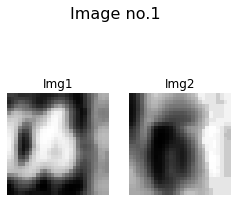

Image no.1
Correct label: 'Same numbers'
0.36668646335601807



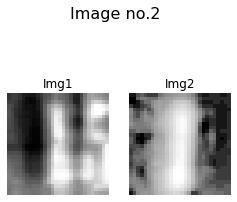

Image no.2
Correct label: 'Same numbers'
0.07983661442995071



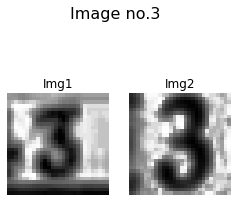

Image no.3
Correct label: 'Same numbers'
0.016616899520158768



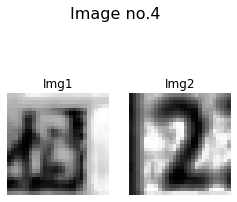

Image no.4
Correct label: 'Different numbers'
1.6806610822677612



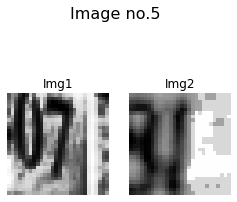

Image no.5
Correct label: 'Different numbers'
1.669623613357544



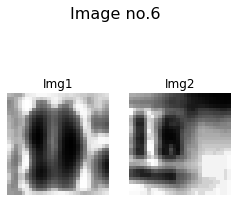

Image no.6
Correct label: 'Different numbers'
0.6704108119010925



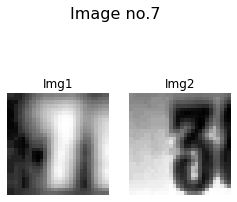

Image no.7
Correct label: 'Different numbers'
2.2012827396392822



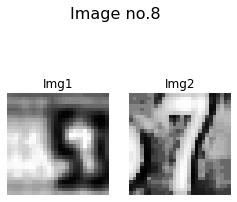

Image no.8
Correct label: 'Different numbers'
2.2419464588165283



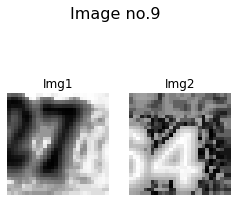

Image no.9
Correct label: 'Different numbers'
2.59602689743042


Images with same number
Mean: 0.4564538598060608
Std: 0.6160957217216492

Images with different number
Mean: 2.05964732170105
Std: 0.4491406977176666

Accuracy 0.89275


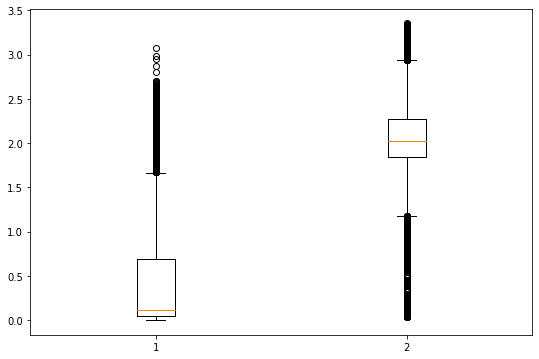

In [26]:
second_config = Pipelines(
    k_fold_splits=5,
    batch_size=1024,
    lr=0.001,
    epochs=10,
    transform=torchvision.transforms.Compose([
        ToNumpy(),
        Resize(),
        GrayScale(),
        EqualizeHist(),
        ToTensor(),
    ]),
    device=device,
    num_workers=1,
    siamese=True
)

print("Running config 2 pipeline")
second_config.all_pipelines()

Running config 3 pipeline
Starting mnist-svhn-mix pipeline
Preprocessing MNIST
MNIST preprocessed
Using downloaded and verified file: data/extra_32x32.mat
Preprocessing SVHN
SVHN preprocessed
--FOLD 1--

--EPOCH 1--
Train loss 0.00162, Train acc 0.78594
Val loss 0.00588, Val acc 0.80892
--EPOCH 2--
Train loss 0.00072, Train acc 0.91731
Val loss 0.00216, Val acc 0.94496
--EPOCH 3--
Train loss 0.00041, Train acc 0.95877
Val loss 0.00172, Val acc 0.95798
--EPOCH 4--
Train loss 0.00033, Train acc 0.97012
Val loss 0.00189, Val acc 0.95033
--EPOCH 5--
Train loss 0.00030, Train acc 0.97258
Val loss 0.00158, Val acc 0.96175
--EPOCH 6--
Train loss 0.00028, Train acc 0.97366
Val loss 0.00191, Val acc 0.95254
--EPOCH 7--
Train loss 0.00027, Train acc 0.97408
Val loss 0.00154, Val acc 0.96229
--EPOCH 8--
Train loss 0.00026, Train acc 0.97508
Val loss 0.00200, Val acc 0.95756
--EPOCH 9--
Train loss 0.00025, Train acc 0.97606
Val loss 0.00149, Val acc 0.96354
--EPOCH 10--
Train loss 0.00023, Train a

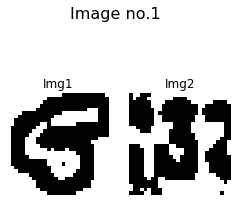

Image no.1
Correct label: 'Different numbers'
1.1790287494659424



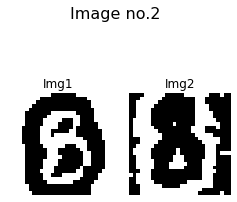

Image no.2
Correct label: 'Same numbers'
0.374576598405838



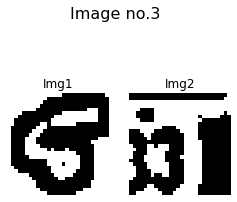

Image no.3
Correct label: 'Different numbers'
1.1058417558670044



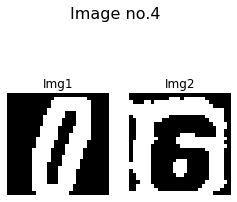

Image no.4
Correct label: 'Different numbers'
2.050095558166504



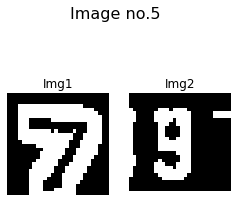

Image no.5
Correct label: 'Different numbers'
1.7130558490753174



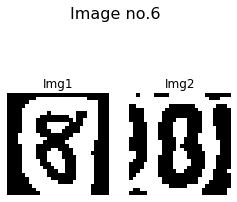

Image no.6
Correct label: 'Same numbers'
0.3755182921886444



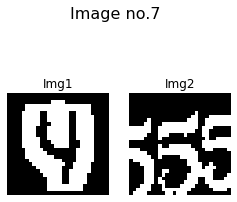

Image no.7
Correct label: 'Different numbers'
1.924168586730957



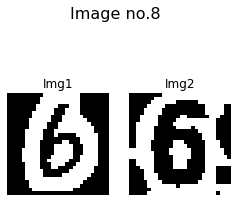

Image no.8
Correct label: 'Same numbers'
0.10646921396255493



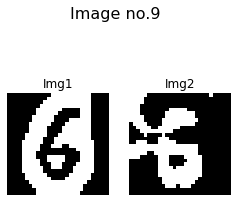

Image no.9
Correct label: 'Same numbers'
0.056523509323596954


Images with same number
Mean: 0.42069387435913086
Std: 0.42151427268981934

Images with different number
Mean: 1.5677928924560547
Std: 0.5316368937492371

Accuracy 0.8836034635879219


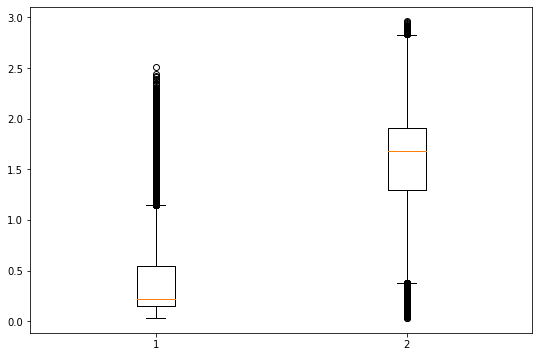

In [27]:
third_config = Pipelines(
    k_fold_splits=5,
    batch_size=1024,
    lr=0.001,
    epochs=10,
    transform=torchvision.transforms.Compose([
        ToNumpy(),
        Resize(),
        GrayScale(),
        AdaptiveThreshold(),
        ToTensor(),
    ]),
    device=device,
    num_workers=1,
    siamese=False
)

print("Running config 3 pipeline")
third_config.mnist_svhn_mix_pipeline()

Running config 4 pipeline
Starting mnist-svhn-mix pipeline
Preprocessing MNIST
MNIST preprocessed
Using downloaded and verified file: data/extra_32x32.mat
Preprocessing SVHN
SVHN preprocessed
--FOLD 1--

--EPOCH 1--
Train loss 0.00154, Train acc 0.79683
Val loss 0.00557, Val acc 0.83696
--EPOCH 2--
Train loss 0.00057, Train acc 0.93851
Val loss 0.00213, Val acc 0.95294
--EPOCH 3--
Train loss 0.00031, Train acc 0.97264
Val loss 0.00165, Val acc 0.96142
--EPOCH 4--
Train loss 0.00025, Train acc 0.97727
Val loss 0.00166, Val acc 0.95992
--EPOCH 5--
Train loss 0.00023, Train acc 0.97850
Val loss 0.00145, Val acc 0.96981
--EPOCH 6--
Train loss 0.00022, Train acc 0.97943
Val loss 0.00124, Val acc 0.97527
--EPOCH 7--
Train loss 0.00021, Train acc 0.98059
Val loss 0.00167, Val acc 0.95788
--EPOCH 8--
Train loss 0.00021, Train acc 0.98020
Val loss 0.00120, Val acc 0.97323
--EPOCH 9--
Train loss 0.00020, Train acc 0.98064
Val loss 0.00135, Val acc 0.96677
--EPOCH 10--
Train loss 0.00019, Train a

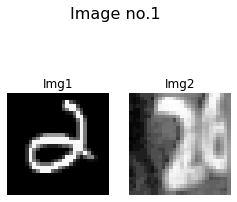

Image no.1
Correct label: 'Same numbers'
0.08103702962398529



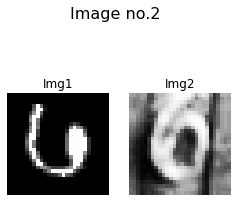

Image no.2
Correct label: 'Same numbers'
1.550404667854309



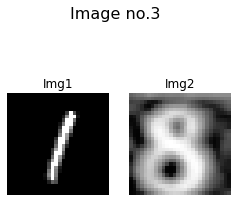

Image no.3
Correct label: 'Different numbers'
1.91388738155365



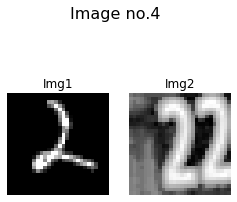

Image no.4
Correct label: 'Same numbers'
0.09320160001516342



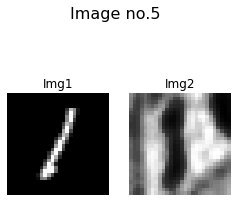

Image no.5
Correct label: 'Same numbers'
0.20850186049938202



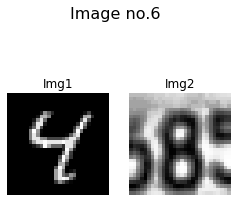

Image no.6
Correct label: 'Different numbers'
2.0386319160461426



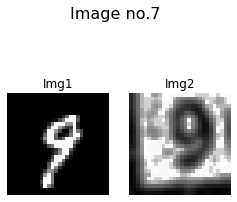

Image no.7
Correct label: 'Same numbers'
0.43655064702033997



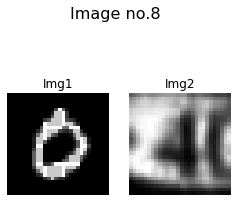

Image no.8
Correct label: 'Different numbers'
1.841139554977417



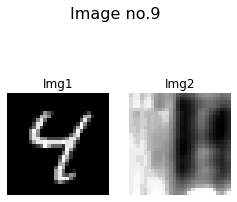

Image no.9
Correct label: 'Different numbers'
1.6373264789581299


Images with same number
Mean: 0.34004130959510803
Std: 0.4230673313140869

Images with different number
Mean: 1.7400577068328857
Std: 0.5559786558151245

Accuracy 0.9101215586145648


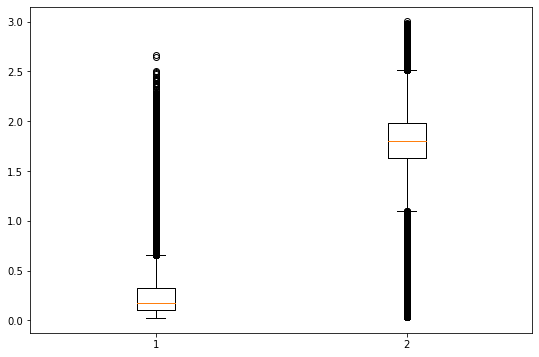

In [28]:
forth_pipeline = Pipelines(
    k_fold_splits=5,
    batch_size=1024,
    lr=0.001,
    epochs=10,
    transform=torchvision.transforms.Compose([
        ToNumpy(),
        Resize(),
        GrayScale(),
        EqualizeHist(),
        ToTensor(),
    ]),
    device=device,
    num_workers=1,
    siamese=False
)

print("Running config 4 pipeline")
forth_pipeline.mnist_svhn_mix_pipeline()